<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br><b>Properties of Main Belt Asteroids in DP0.3</b> <br>
Contact author(s): Jeff Carlin <br>
Last verified to run: <i>yyyy-mm-dd</i> <br>
LSST Science Pipelines version: Weekly <i>yyyy_xx</i> <br>
Container Size: <i>medium</i> <br>
Targeted learning level: <i>beginner</i> <br>

_In this template, text in italics are examples or instructions that should be: (a) removed if it is not applicable to the notebook; or (b) replaced with text that is appropriate for the notebook. But bold or regular text should appear pretty much as-is in all CET notebooks. For more information, see the [CET's Guidelines for Tutorial Notebooks](https://confluence.lsstcorp.org/pages/viewpage.action?pageId=168857070)._

_While developing, use the following code cell to check that the code conforms to standards, but then delete the cell and "Kernel --> Restart Kernel and Clear All Outputs" before saving and committing._

In [2]:
#%load_ext pycodestyle_magic
#%flake8_on
#import logging
#logging.getLogger("flake8").setLevel(logging.FATAL)

_The six cells below are considered the extended header of the notebook. The first four will be used, verbatim, to create the table of notebook metadata in the README.md file for the repository._

**Description:** _Very brief description of notebook._

**Skills:** _Brief list of skills to match the README.md file for the repository._

**LSST Data Products:** _List the all of the types of LSST catalogs and images used._

**Packages:** _List the python packages used._ (_List the packages being taught first, e.g., afwDisplay for a notebook about displaying images. Then supporting packages, e.g., lsst.daf.butler for a notebook about displaying images. It is OK to leave out basic support packages like os or glob.)_

**Credit:**
_E.g., "Originally developed by" or "Based on notebooks developed by" and then people's names, including journal article or software release citations if appropriate._
Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks.

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0-3.lsst.io">dp0-3.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

_Provide a light narrative about this notebook, e.g., "This notebook will teach the user..."._

_Cite or link to any external information or documentation, and cross-reference to other notebooks._

### 1.1 Package Imports

_All package imports should be done in the first code cell._

_Provide explanation or external links to package documentation, where appropriate._

_E.g., Numpy is a fundamental package for scientific computing with arrays in Python (<a href="https://numpy.org">numpy.org</a>)._

_Use code cell comments to describe the packages being imported._

In [3]:
# general python packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
plt.style.use('tableau-colorblind10')

# LSST package for TAP queries
from lsst.rsp import get_tap_service, retrieve_query

In [4]:
service = get_tap_service("ssotap")

Note: we are retrieving a lot of rows...

###ll of the 14.6 million rows from MPCORB, so each of the next two queries may take a few minutes.

In [52]:
df_mpc_sso = service.search("SELECT mpc.ssObjectId, mpc.e, mpc.incl, mpc.q, mpc.peri, \
                            sso.ssObjectId, sso.uH, sso.gH, sso.rH, sso.iH, sso.zH, sso.yH \
                            FROM dp03_catalogs.MPCORB as mpc \
                            JOIN dp03_catalogs.SSObject as sso \
                            ON mpc.ssObjectId = sso.ssObjectId \
                            WHERE mpc.ssObjectId < 9223370875126069107 AND mpc.ssObjectId > 7331137166374808576 \
                            AND sso.numObs > 50").to_table().to_pandas()

print('The query returned ',len(df_mpc_sso),' results.')

The query returned  445093  results.


### 1.2 Define Functions and Parameters

_If your notebook defines functions or parameters to use later or throughout, do it here in sub-section 1.2._

_It is OK to rename the subsection to be more specific to the notebook, and/or to use sub-sub-sections like "1.2.1 Define global cosmological parameter values" or "1.2.2 Define a function to make an image cutout"._

_It is OK to remove this sub-section if it is not being used._

In [53]:
def calc_semimajor_axis(q, e):
    """
    Given a perihelion distance and orbital eccentricity,
      calculate the semi-major axis of the orbit.

    Parameters
    ----------
    q: float
        Distance at perihelion, in AU.
    e: float
        Orbital eccentricity.

    Returns
    -------
    a: float
        Semi-major axis of the orbit, in AU.
        q = a(1-e), so a = q/(1-e)
    """

    return q/(1.0-e)

In [54]:
def get_obj_matched(objid):
    """
    Given an objectId, retrieve all measurements from
      SSSource for that object.

    Parameters
    ----------
    objid: int64
        ObjectId of the object of interest.

    Returns
    -------
    allsrc: dataframe
        Measurements for the object from the DP0.3 SSSource table.
    """

    allsrc = service.search("SELECT * FROM dp03_catalogs.DiaSource as diasrc \
                                 JOIN dp03_catalogs.SSSource as sssrc \
                                 ON diasrc.diaSourceId = sssrc.diaSourceId \
                                 WHERE diasrc.ssObjectId = " + str(objid)).to_table().to_pandas()

    return allsrc

In [89]:
def xyz_orbit_plot_manyobjects(tobs_list, x_list, y_list, z_list, title=None):
    """
    Given lists (of lists) of observation times and XYZ coordinates,
      plot the orbits of multiple SS objects.

    Parameters
    ----------
    tobs_list: list of lists
        MidpointTAI times of each observation of each object.
    {xyz}_list: list of lists
        Solar system positions of each observation of each object.
        Can be either heliocentric or topocentric.

    """

    params = {
       'axes.labelsize': 12,
       'font.size': 12,
       'legend.fontsize': 8,
       'xtick.major.width': 2,
       'xtick.minor.width': 1,
       'xtick.major.size': 6,
       'xtick.minor.size': 4,
       'xtick.direction': 'in',
       'xtick.top': True,
       'lines.linewidth':2,
       'axes.linewidth':2,
       'axes.labelweight':2,
       'axes.titleweight':3,
       'ytick.major.width':2,
       'ytick.minor.width':1,
       'ytick.major.size': 6,
       'ytick.minor.size': 4,
       'ytick.direction': 'in',
       'ytick.right': True,
       'text.usetex': False,
       'figure.figsize': [6, 6],
       'figure.facecolor': 'white'
       }
    
    plt.rcParams.update(params)
    
    fig = plt.figure()
    fig.subplots_adjust(hspace=0, wspace=0)

    for i in range(len(tobs_list)):
        dist = np.sqrt(x_list[i]**2 + y_list[i]**2 + z_list[i]**2)
        col = (np.random.random(), np.random.random(), np.random.random())

        ax1=plt.subplot(221)
        ax1.plot(x_list[i], z_list[i], '.', color=col, ms=5)
        ax1.set_ylabel('Z (AU)')
        ax1.set_xlabel('X (AU)')
        if title:
            ax1.set_title(title)
        ax1.minorticks_on()

        ax2=plt.subplot(222, sharey=ax1)
        ax2.plot(y_list[i], z_list[i], '.', color=col, ms=5)
        ax2.set_xlabel('Y (AU)')
        ax2.minorticks_on()
        plt.setp(ax2.get_yticklabels(), visible=False)

        ax3=plt.subplot(223, sharex=ax1)
        ax3.plot(x_list[i], y_list[i], '.', color=col, ms=5)
        ax3.set_ylabel('Y (AU)')
        ax3.set_xlabel('X (AU)')
        ax3.minorticks_on()

    plt.show()

In [56]:
plt.style.use('tableau-colorblind10')
%matplotlib inline

params = {'axes.labelsize': 20,
          'font.size': 20,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 8,
          'xtick.minor.size': 4,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 8,
          'ytick.minor.size': 4,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [6, 6],
          'figure.facecolor': 'White'
          }
plt.rcParams.update(params)

## 2. Orbital parameters of Solar System objects

### 2.1 Over the entire Solar System

First, calculate the semi-major axis of each object's orbit.

In [57]:
a = calc_semimajor_axis(df_mpc_sso.q, df_mpc_sso.e)

Plot the orbital inclination and the eccentricity vs. semi-major axis. Note that we plot the sine of the inclination so its range is limited to values between 0 and 1.

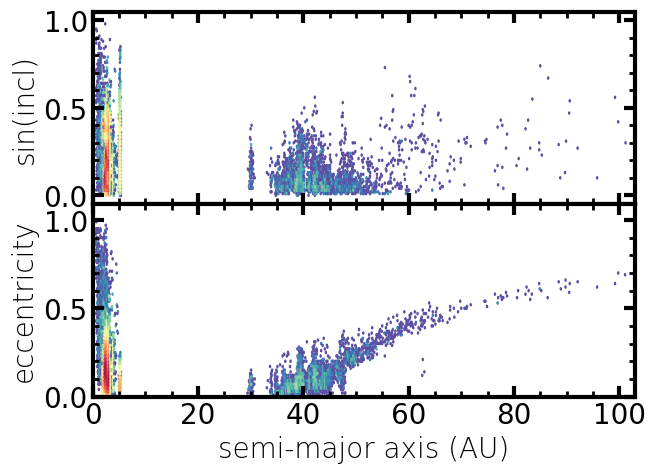

In [58]:
fig, axs = plt.subplots(2, 1, figsize=(7, 5), sharex=True)
fig.subplots_adjust(hspace = 0)

axs[0].hexbin(a, np.sin(np.deg2rad(df_mpc_sso.incl)),
              gridsize=(int(103/0.2), 50), cmap='Spectral_r', bins='log',
              extent=(0, 103, 0, 1))
axs[0].set_ylabel('sin(incl)')
axs[0].minorticks_on()
axs[0].set_xlim(0, 103)

axs[1].hexbin(a, df_mpc_sso.e,
              gridsize=(int(103/0.2), 50), cmap='Spectral_r', bins='log',
              extent=(0, 103, 0, 1))
axs[1].set_ylabel('eccentricity')
axs[1].set_xlabel('semi-major axis (AU)')

#avals = np.arange(10, 110, 0.5)
#qvals = np.arange(25, 55, 5)
#evals = np.arange(0, 1, 0.01)

## q = a(1-e)
## q/a = 1-e
## e = 1-q/a

#for q in qvals:
#    axs[1].plot(avals, 1-(q/avals), linestyle=':', color='Black')

axs[1].set_xlim(0, 103)
axs[1].set_ylim(0, 1.09)
axs[1].minorticks_on()
plt.show()
plt.close()

This plot shows Solar System objects extending out to at least 100 AU, but that the majority of objects are in the inner Solar System (at less than 6 AU). For the rest of this notebook, we will focus on the so-called "Main Belt" asteroids with semi-major axes between the Earth and Jupiter. (The outer Solar System bodies will be the subject of another notebook.)

### 2.2 Main Belt Asteroids -- Objects outside Earth's orbit (a > 1 AU) and inside Jupiter's position (a < 5 AU)

#### 2.2.1 Semi-major axes of Main Belt asteroids

This plot shows Solar System objects extending out to at least 100 AU, but that the majority of objects are in the inner Solar System (at less than 10 AU). For the rest of this notebook, we will focus on the so-called "Main Belt" asteroids with semi-major axes between the Earth and Jupiter. (The outer Solar System bodies will be the subject of another notebook.)

Before we get into the orbital elements of the Main Belt population, let's just see where they are located in the Solar System (via their `semi-major axis (a)`):

In [59]:
main_belt = (a > 1.2) & (a < 4.7)

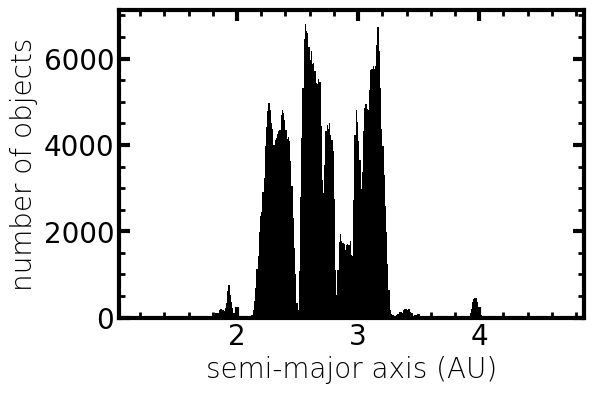

In [62]:
fig = plt.figure(figsize=(6, 4))

plt.hist(a[main_belt], bins=np.arange(1.2, 4.7, 0.01), color='Black')
plt.xlabel('semi-major axis (AU)')
plt.ylabel('number of objects')
plt.minorticks_on()
plt.show()

Interesting -- it's not just a "belt" between 2-3.5 AU, it has some "gaps" where there are very few (or no) objects. These are known as [Kirkwood gaps](https://en.wikipedia.org/wiki/Kirkwood_gap), which arise due to resonances between the asteroid's orbital period and that of Jupiter. (For example, at a=2.5 AU, an asteroid orbits 3 times for each single orbit of Jupiter, and is thus in a "3:1 resonance". Here's a figure illustrating the positions of some of the resonances, and the names of some of the prominent families ([source](http://burro.cwru.edu/Academics/Astr221/Gravity/resonance.html)).

<img src="kirkwood_resonances.gif" width="350">

You can see that the Hildas, Cybeles, and Hungarias are clearly visible in the DP0.3 dataset.

Now we look at their closest approach to the Sun in their orbits, known as the `perihelion distance (q)`:

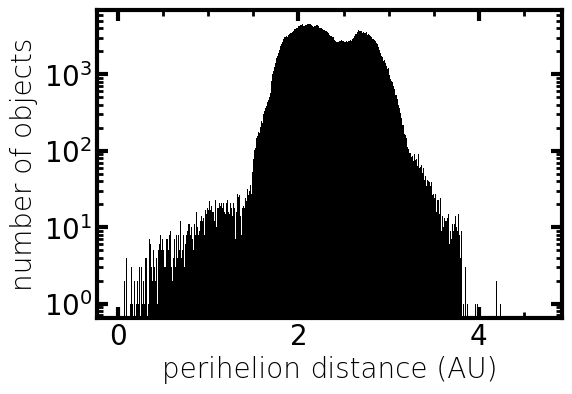

In [63]:
fig = plt.figure(figsize=(6, 4))

plt.hist(df_mpc_sso[main_belt].q, bins=np.arange(0.0, 4.7, 0.01), 
         color='Black', log=True)
plt.xlabel('perihelion distance (AU)')
plt.ylabel('number of objects')
plt.minorticks_on()
plt.show()

Hmmm... Should we be concerned that some of those cross the Earth's orbit at 1 AU(!)?

#### 2.2.2 Orbital properties of Main Belt asteroids

<img src="Kirkwood-20060509.png" width="250">

The above illustration (from the Wikipedia article on Kirkwood gaps) shows planets as large orange circles, and asteroids as small dots of various colors. The Main Belt is clear as a large ring outside Mars' orbit (and inside Jupiter's), and you can clearly see the Kirkwood gaps in the Main Belt. But we can go even further by classifying objects based on their orbital properties.

The following figure is from the [Grav et al. 2011 paper](https://ui.adsabs.harvard.edu/abs/2011PASP..123..423G/abstracthttps://ui.adsabs.harvard.edu/abs/2011PASP..123..423G/abstract) describing the PanSTARRS Synthetic Solar System Model, which (in part) forms the basis of DP0.3's simulated dataset. This figure shows the orbital inclinations and eccentricities of "Main Belt Asteroids" (i.e., those with orbital semi-major axes between 1-5 AU, and with pericenters larger than 1.5 AU) as a function of their semi-major axis.

<img src="ps1_ss_paper_fig5_mainbelt.jpeg" width="350">

Let's make a similar plot for DP0.3 data and see how it compares to the earlier simulation. (First, we'll make the cut to remove objects with pericenters < 1.5 AU.)

In [67]:
not_near_earth_peri = df_mpc_sso.q > 1.5

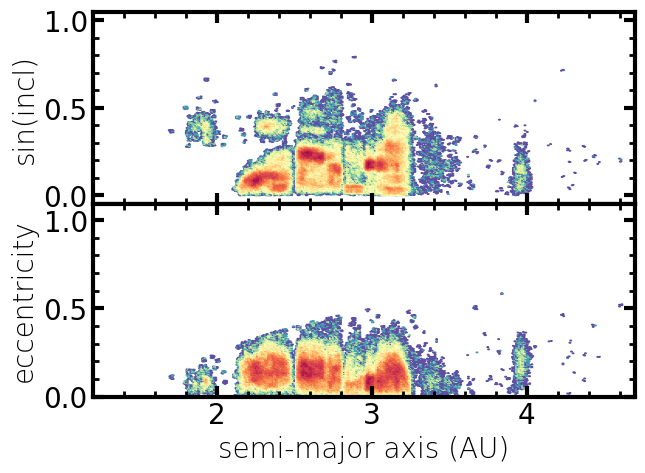

In [68]:
fig, axs = plt.subplots(2, 1, figsize=(7, 5), sharex=True)
fig.subplots_adjust(hspace = 0)

axs[0].hexbin(a[not_near_earth_peri], np.sin(np.deg2rad(df_mpc_sso[not_near_earth_peri].incl)),
              gridsize=(int(4.7/0.01), 200), cmap='Spectral_r', bins='log',
              extent=(0, 4.7, 0, 1))
axs[0].set_ylabel('sin(incl)')
axs[0].minorticks_on()
axs[0].set_xlim(0, 103)

axs[1].hexbin(a[not_near_earth_peri], df_mpc_sso[not_near_earth_peri].e,
              gridsize=(int(4.7/0.01), 200), cmap='Spectral_r', bins='log',
              extent=(0, 4.7, 0, 1))
axs[1].set_ylabel('eccentricity')
axs[1].set_xlabel('semi-major axis (AU)')

axs[1].set_xlim(1.2, 4.7)
axs[1].set_ylim(0, 1.09)
axs[1].minorticks_on()
plt.show()
plt.close()

## 3. Orbit families among Main Belt asteroids

Besides the Kirkwood gaps, the distribution of asteroids in the above plot clearly shows concentrations ("blobs") of objects that share similar orbital properties. Let's examine those in more detail.

We will follow the analysis from this [Parker et al. 2008](https://ui.adsabs.harvard.edu/abs/2008Icar..198..138P/abstract) paper, which examined orbit families among Main Belt asteroids observed by SDSS. (See also [Ivezic et al. 2002](https://ui.adsabs.harvard.edu/abs/2002AJ....124.2943I/abstract) and Chapter 5 of the [LSST Science Book](https://ui.adsabs.harvard.edu/abs/2009arXiv0912.0201L/abstract).)

<img src="parker2008_orbit_families_sini_vs_a.png" width=300>

First, we will divide the Main Belt asteroids into the following subsets, as in the above figure:
- inner belt: 1.2 < a < 2.5 AU
- mid belt: 2.5 < a < 2.82 AU
- outer belt: 2.82 < a < 3.25 AU

Then, we will plot `sin(incl)` (inclination) vs. `eccentricity (e)` to compare to the following figure from the Parker et al. paper (apologies for the low resolution -- the x-axis is "e" and the y-axis "sin(i)"):

<img src="parker2008_orbit_families_sini_vs_e.png" width=500>

In [73]:
inner_belt = (a > 1.2) & (a < 2.5) & not_near_earth_peri
mid_belt = (a >= 2.5) & (a < 2.82) & not_near_earth_peri
outer_belt = (a > 2.82) & (a < 3.25) & not_near_earth_peri

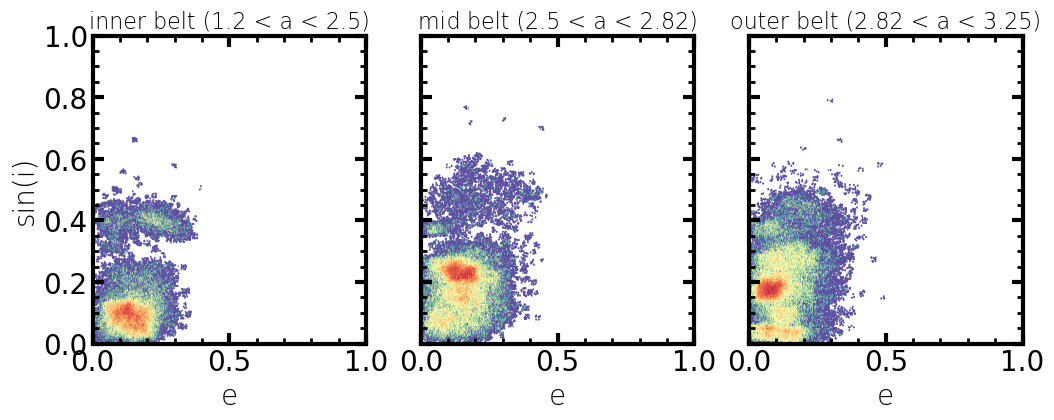

In [79]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

axs[0].hexbin(df_mpc_sso[inner_belt].e, np.sin(np.deg2rad(df_mpc_sso[inner_belt].incl)), gridsize=300, bins='log', cmap='Spectral_r')
axs[0].set_xlabel('e')
axs[0].set_ylabel('sin(i)')
axs[0].set_xlim(0, 1)
axs[0].set_ylim(0, 1)
axs[0].minorticks_on()
axs[0].set_title(r'inner belt (1.2 < a < 2.5)', fontsize=16)

axs[1].hexbin(df_mpc_sso[mid_belt].e, np.sin(np.deg2rad(df_mpc_sso[mid_belt].incl)), gridsize=300, bins='log', cmap='Spectral_r')
axs[1].set_xlabel('e')
axs[1].set_xlim(0, 1)
axs[1].set_ylim(0, 1)
axs[1].minorticks_on()
axs[1].set_title(r'mid belt (2.5 < a < 2.82)', fontsize=16)

axs[2].hexbin(df_mpc_sso[outer_belt].e, np.sin(np.deg2rad(df_mpc_sso[outer_belt].incl)), gridsize=300, bins='log', cmap='Spectral_r')
axs[2].set_xlabel('e')
axs[2].set_xlim(0, 1)
axs[2].set_ylim(0, 1)
axs[2].minorticks_on()
axs[2].set_title(r'outer belt (2.82 < a < 3.25)', fontsize=16)

plt.show()

As you could see in the plot from the Parker et al. paper above, most of the "blobs" are at low inclinations and low eccentricities. Zoom in on the lower-left portion:

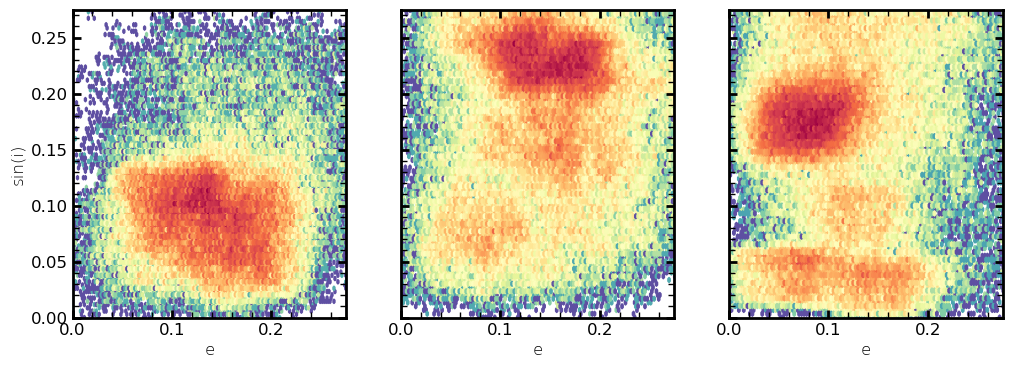

In [99]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

axs[0].hexbin(df_mpc_sso[inner_belt].e, np.sin(np.deg2rad(df_mpc_sso[inner_belt].incl)), gridsize=200, bins='log', cmap='Spectral_r')
axs[0].set_xlabel('e')
axs[0].set_ylabel('sin(i)')
axs[0].set_xlim(0, 0.275)
axs[0].set_ylim(0, 0.275)
axs[0].minorticks_on()

axs[1].hexbin(df_mpc_sso[mid_belt].e, np.sin(np.deg2rad(df_mpc_sso[mid_belt].incl)), gridsize=200, bins='log', cmap='Spectral_r')
axs[1].set_xlabel('e')
axs[1].set_xlim(0, 0.275)
axs[1].set_ylim(0, 0.275)
axs[1].minorticks_on()

axs[2].hexbin(df_mpc_sso[outer_belt].e, np.sin(np.deg2rad(df_mpc_sso[outer_belt].incl)), gridsize=200, bins='log', cmap='Spectral_r')
axs[2].set_xlabel('e')
axs[2].set_xlim(0, 0.275)
axs[2].set_ylim(0, 0.275)
axs[2].minorticks_on()

plt.show()


<img src="parker2008_orbit_families_sini_vs_e.png" width=600>

Again, here's the figure from the Parker et al. paper for comparison. You can see that many of the same features are present. One could look into those features in more detail (indeed, many of them are _named_ orbital families), but that is beyond the scope of this notebook.

Finally, to give some intuition about what the actual _orbits_ of these orbital families look like, we will plot them in heliocentric (Sun-centered) Cartesion (XYZ) coordinates. We'll plot 10 randomly-selected objects from "blobs" (i.e., orbital families) in the inner, mid, and outer belts in three separate plots.

First, here's a plot overlaying the boxes we'll select from:

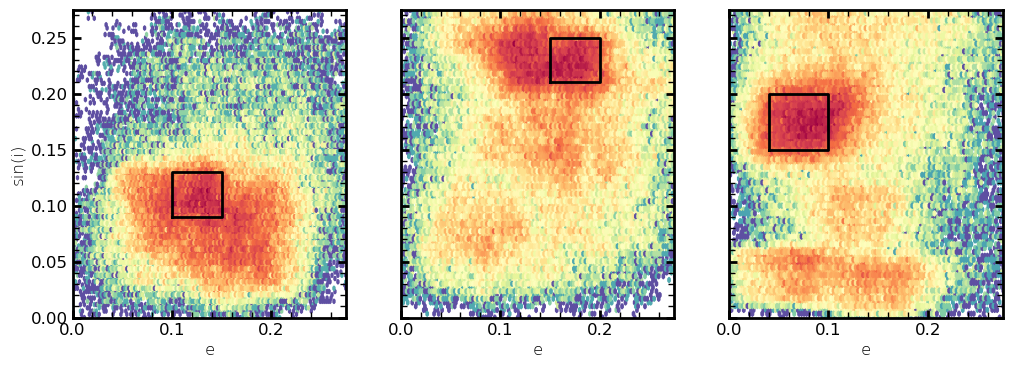

In [127]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

axs[0].hexbin(df_mpc_sso[inner_belt].e, np.sin(np.deg2rad(df_mpc_sso[inner_belt].incl)), gridsize=200, bins='log', cmap='Spectral_r')
axs[0].plot([0.1, 0.1, 0.15, 0.15, 0.1], [0.09, 0.13, 0.13, 0.09, 0.09], color='Black')
axs[0].set_xlabel('e')
axs[0].set_ylabel('sin(i)')
axs[0].set_xlim(0, 0.275)
axs[0].set_ylim(0, 0.275)
axs[0].minorticks_on()

axs[1].hexbin(df_mpc_sso[mid_belt].e, np.sin(np.deg2rad(df_mpc_sso[mid_belt].incl)), gridsize=200, bins='log', cmap='Spectral_r')
axs[1].plot([0.15, 0.15, 0.2, 0.2, 0.15], [0.21, 0.25, 0.25, 0.21, 0.21], color='Black')
axs[1].set_xlabel('e')
axs[1].set_xlim(0, 0.275)
axs[1].set_ylim(0, 0.275)
axs[1].minorticks_on()

axs[2].hexbin(df_mpc_sso[outer_belt].e, np.sin(np.deg2rad(df_mpc_sso[outer_belt].incl)), gridsize=200, bins='log', cmap='Spectral_r')
axs[2].plot([0.04, 0.04, 0.1, 0.1, 0.04], [0.15, 0.2, 0.2, 0.15, 0.15], color='Black')
axs[2].set_xlabel('e')
axs[2].set_xlim(0, 0.275)
axs[2].set_ylim(0, 0.275)
axs[2].minorticks_on()

plt.show()


These first three cells below pick 10 objects at random, then use the `get_obj_matched` function defined above to select all measurements of each object from the SSSource table. The next three cells use the orbit plotting function we defined above to plot them.

In [134]:
inner_blob = (df_mpc_sso.e > 0.1) & (df_mpc_sso.e < 0.15) & \
             (np.sin(np.deg2rad(df_mpc_sso.incl)) < 0.13) & \
             (np.sin(np.deg2rad(df_mpc_sso.incl)) > 0.09)

nobj_to_plot = 10
pick_obj_inner = df_mpc_sso[inner_belt & inner_blob].sample(nobj_to_plot)

pick_obj_torb_inner = []
pick_obj_x_inner = []
pick_obj_y_inner = []
pick_obj_z_inner = []

for i in range(nobj_to_plot):
    src_cat_obj = get_obj_matched(pick_obj_inner.ssObjectId.values[i])
    pick_obj_torb_inner.append(src_cat_obj['midPointTai'])
    pick_obj_x_inner.append(src_cat_obj['heliocentricX'])
    pick_obj_y_inner.append(src_cat_obj['heliocentricY'])
    pick_obj_z_inner.append(src_cat_obj['heliocentricZ'])

In [135]:
mid_blob = (df_mpc_sso.e > 0.15) & (df_mpc_sso.e < 0.2) & \
           (np.sin(np.deg2rad(df_mpc_sso.incl)) < 0.25) & \
           (np.sin(np.deg2rad(df_mpc_sso.incl)) > 0.21)

nobj_to_plot = 10
pick_obj_mid = df_mpc_sso[mid_belt & mid_blob].sample(nobj_to_plot)

pick_obj_torb_mid = []
pick_obj_x_mid = []
pick_obj_y_mid = []
pick_obj_z_mid = []

for i in range(nobj_to_plot):
    src_cat_obj = get_obj_matched(pick_obj_mid.ssObjectId.values[i])
    pick_obj_torb_mid.append(src_cat_obj['midPointTai'])
    pick_obj_x_mid.append(src_cat_obj['heliocentricX'])
    pick_obj_y_mid.append(src_cat_obj['heliocentricY'])
    pick_obj_z_mid.append(src_cat_obj['heliocentricZ'])

In [136]:
outer_blob = (df_mpc_sso.e > 0.04) & (df_mpc_sso.e < 0.1) & \
             (np.sin(np.deg2rad(df_mpc_sso.incl)) < 0.2) & \
             (np.sin(np.deg2rad(df_mpc_sso.incl)) > 0.15)

nobj_to_plot = 10
pick_obj_outer = df_mpc_sso[outer_belt & outer_blob].sample(nobj_to_plot)

pick_obj_torb_outer = []
pick_obj_x_outer = []
pick_obj_y_outer = []
pick_obj_z_outer = []

for i in range(nobj_to_plot):
    src_cat_obj = get_obj_matched(pick_obj_outer.ssObjectId.values[i])
    pick_obj_torb_outer.append(src_cat_obj['midPointTai'])
    pick_obj_x_outer.append(src_cat_obj['heliocentricX'])
    pick_obj_y_outer.append(src_cat_obj['heliocentricY'])
    pick_obj_z_outer.append(src_cat_obj['heliocentricZ'])

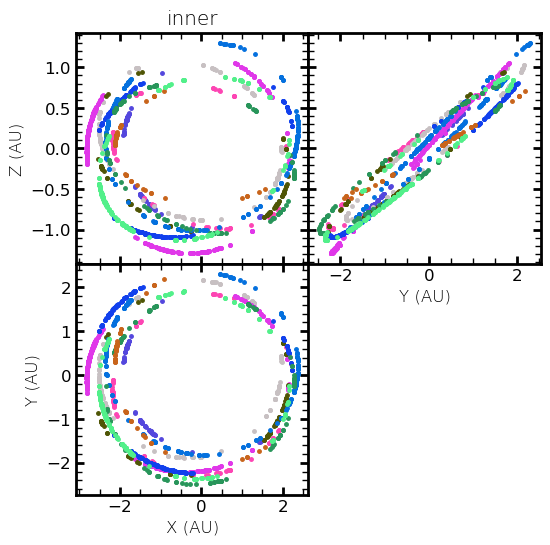

In [137]:
xyz_orbit_plot_manyobjects(pick_obj_torb_inner, pick_obj_x_inner,
                           pick_obj_y_inner, pick_obj_z_inner, title='inner')

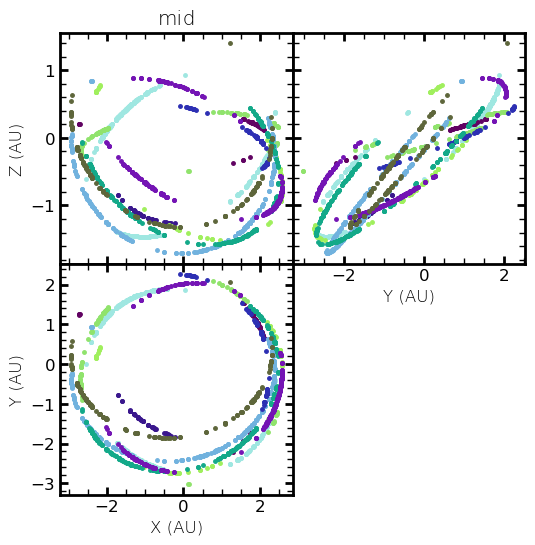

In [138]:
xyz_orbit_plot_manyobjects(pick_obj_torb_mid, pick_obj_x_mid,
                           pick_obj_y_mid, pick_obj_z_mid, title='mid')

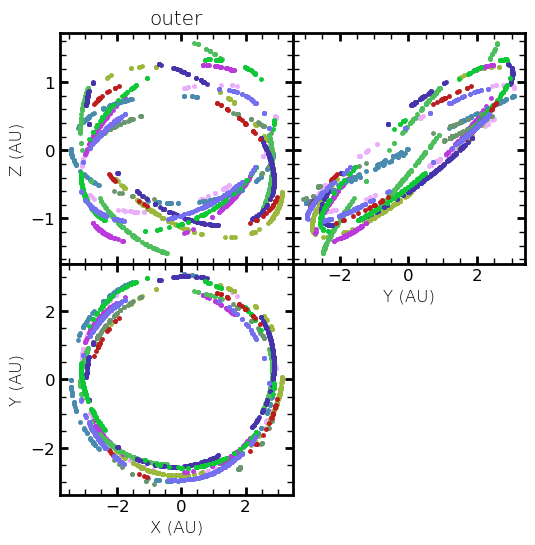

In [139]:
xyz_orbit_plot_manyobjects(pick_obj_torb_outer, pick_obj_x_outer,
                           pick_obj_y_outer, pick_obj_z_outer, title='outer')

There are small differences between the orbits of these families, but nothing dramatic. (Though that may not be surprising given how similar the inclinations and eccentricities of the different families we selected were in the first place.) This demonstrates that more exploration would be required to really understand and classify the different families.

### 4. Exercises for the learner

1. Explore the properties of other families in the Main Belt. Do their orbits look different than the ones we've examined so far?

2. Figure out whether the Main Belt asteroids with perihelion distance less than 1.5 AU make a close approach to the Earth.

3. Compare properties of Main Belt asteroids with those elsewhere in the Solar System.